# Inicializações

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,IsolationForest
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, precision_score, f1_score
# from pmdarima import auto_arima
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
df = pd.read_csv(r'C:\Users\jvict\OneDrive\Documentos\GitHub\MBA-DSA-TCC\MetroPT3AirCompressor.csv') # Load dataset
# 'Unnamed: 0', 'timestamp', 'TP2', 'TP3', 'H1', 'DV_pressure','Reservoirs', 'Oil_temperature', 'Motor_current', 'COMP', 'DV_eletric','Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses'

df['timestamp'] = pd.to_datetime(df.timestamp) # Change data type to datetime
df.rename(columns={'timestamp':'ds'}, inplace=True) # Rename datetime column

df['COMP'] = df['COMP'].astype(bool)
df['DV_eletric'] = df['DV_eletric'].astype(bool)
df['Towers'] = df['Towers'].astype(bool)
df['MPG'] = df['MPG'].astype(bool)
df['LPS'] = df['LPS'].astype(bool)
df['Pressure_switch'] = df['Pressure_switch'].astype(bool)
df['Oil_level'] = df['Oil_level'].astype(bool)
df['Caudal_impulses'] = df['Caudal_impulses'].astype(bool)

defect1 = (df.ds > '2020-04-18 00:00:00') & (df.ds < '2020-04-18 23:59:00')
defect2 = (df.ds > '2020-05-29 23:30:00') & (df.ds < '2020-05-30 06:00:00')
defect3 = (df.ds > '2020-06-05 10:00:00') & (df.ds < '2020-06-07 14:30:00')
defect4 = (df.ds > '2020-07-15 14:30:00') & (df.ds < '2020-07-15 19:00:00')

df['y'] = defect1 | defect2 | defect3 | defect4 # Insert defect column when it occurs, accordingly the data description

colunas_numericas = df.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
df[colunas_numericas] = scaler.fit_transform(df[colunas_numericas])

# Definindo funções

In [12]:
def plotar_falhas(dataframe, dataframe_maior):
    plt.figure(figsize=(25, 4))

    plots = [(dataframe.ds > '2020-04-17 15:00:00') & (dataframe.ds < '2020-04-19 03:00:00'),
             (dataframe.ds > '2020-05-29 20:00:00') & (dataframe.ds < '2020-05-30 08:00:00'),
             (dataframe.ds > '2020-06-05 04:00:00') & (dataframe.ds < '2020-06-08 23:00:00'),
             (dataframe.ds > '2020-07-15 10:00:00') & (dataframe.ds < '2020-07-15 23:00:00')]

    for i, plot in enumerate(plots):
        plt.subplot(4, 1, i+1)
        try:
            plt.plot(dataframe[plot].ds, dataframe[plot].yh*.85, label='Predicted', linestyle='-.')
        except:
            pass
        try:
            plt.plot(dataframe[plot].ds, dataframe[plot].y_h_filtered, label='Predicted filtered')
        except:
            pass
        plt.plot(dataframe[plot].ds, dataframe[plot].y*.7, label='Actual', linestyle='-.')
        plt.legend()
    plt.show()

    plt.figure(figsize=(25, 2))
    try:
        plt.plot(dataframe_maior.ds, dataframe_maior.yh*.85, label='Predicted', linestyle='-.')
    except:
        pass
    try:
        plt.plot(dataframe_maior.ds, dataframe_maior.y_h_filtered, label='Predicted filtered')
    except:
        pass
    plt.plot(dataframe_maior.ds, dataframe_maior.y*.7, label='Actual', linestyle='-.')
    plt.legend()
    plt.show()
    
    
def avaliarModelo(X_test, y_test, y_predicted, df, filtro_minutos=50):
    df_out = X_test.copy()
    df_out['y'] = y_test
    df_out['yh'] = y_predicted
    df_out['ds'] = df.ds

    #####################################################################################
    #####################################################################################

    y_true = df_out.y[~np.isnan(df_out.yh)]
    y_pred = df_out.yh[~np.isnan(df_out.yh)]

    # Calcular a acurácia
    try:
        print(f'accuracy: {accuracy_score(y_true, y_pred)}')
    except:
        pass
    
    try:
        print(f'\nprecision: {precision_score(y_true, y_pred)}')
    except:
        pass
    
    try:
        print(f'\nf1: {f1_score(y_true, y_pred)}')
    except:
        pass

    filtro_tempo = filtro_minutos # Mantém os defeitos somente se durarem mais que X minutos
    df_out['periodo'] = (df_out.yh != df_out.yh.shift()).cumsum()
    filtered_df = df_out[df_out.yh == 1]
    duracao_periodos = filtered_df.groupby('periodo')['ds'].agg(['min', 'max'])
    duracao_periodos['duracao'] = (duracao_periodos['max'] - duracao_periodos['min']).dt.total_seconds() / 60
    periodos_validos = duracao_periodos[duracao_periodos['duracao'] >= filtro_tempo].index
    df_out['y_h_filtered'] = df_out[df_out['periodo'].isin(periodos_validos)].yh
    df_out.drop('periodo', axis=1)
    df_out = df_out.fillna(False)

    plotar_falhas(dataframe=df_out, dataframe_maior=df_out)#[(df['ds'] > '2020-03-29 09:30:00') & (df['ds'] < '2020-03-30 09:30:00')])

In [4]:
def filtrar_df(colunas, df_treino):
    df_part = df.copy()
    if colunas:
        df_part = df_part[colunas]
    train = df_part[df_treino]
    X_train, y_train = train.drop('y', axis=1).drop('ds', axis=1), train.y
    X_test, y_test = df_part.drop('y', axis=1).drop('ds', axis=1), df_part.y
    return df_part, X_train, y_train, X_test, y_test

# Modelos de classificação

## Usando Random Forest

accuracy: 0.9927980392208566

precision: 0.7570868801513309

f1: 0.836835581044551


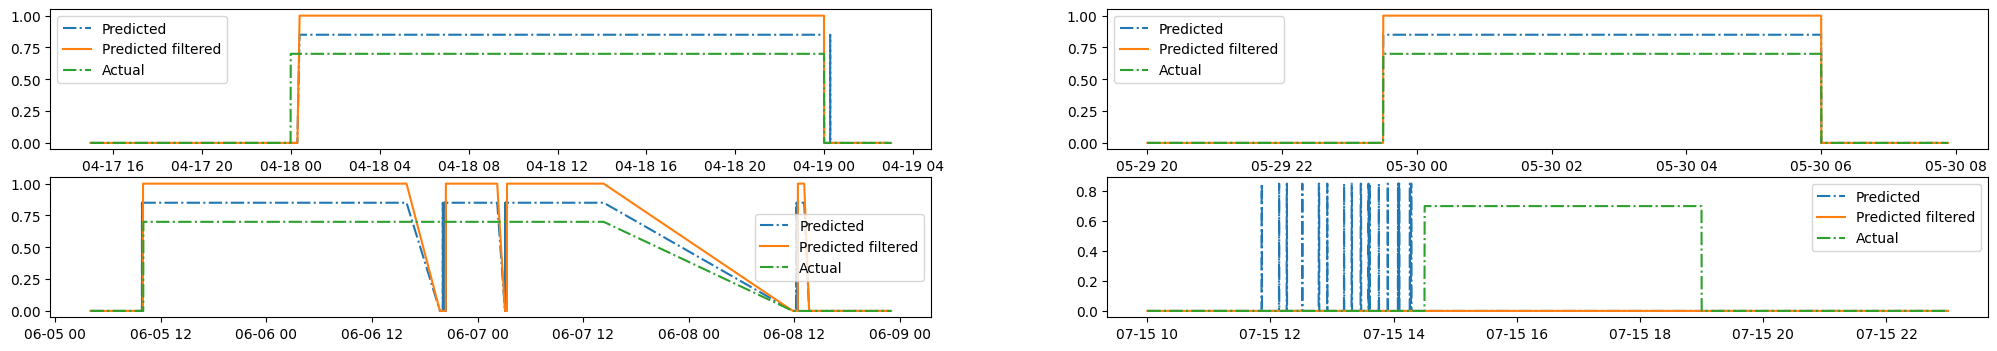

c:\Users\jvict\OneDrive\Documentos\GitHub\MBA-DSA-TCC\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


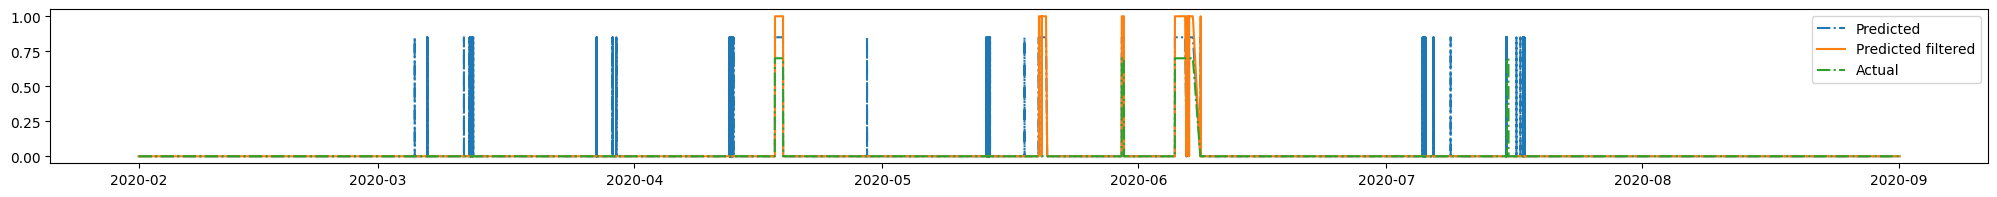

In [5]:
part = (df['ds'] > '2020-04-15 00:00:00') & (df['ds'] < '2020-04-22 23:59:00') | (df['ds'] > '2020-05-27 23:30:00') & (df['ds'] < '2020-06-03 14:30:00')
df_part, X_train, y_train, X_test, y_test = filtrar_df(['ds', 'DV_pressure', 'Oil_temperature', 'TP2', 'Motor_current', 'H1', 'MPG', 'DV_eletric', 'COMP', 'y'], df_treino=part)
randomForest = RandomForestClassifier(max_depth=28, random_state=0).fit(X_train, y_train)
avaliarModelo(X_test, y_test, randomForest.predict(X_test), df, filtro_minutos=15)

accuracy: 0.9906944733768066

precision: 0.6831174838112859

f1: 0.8071373920647065


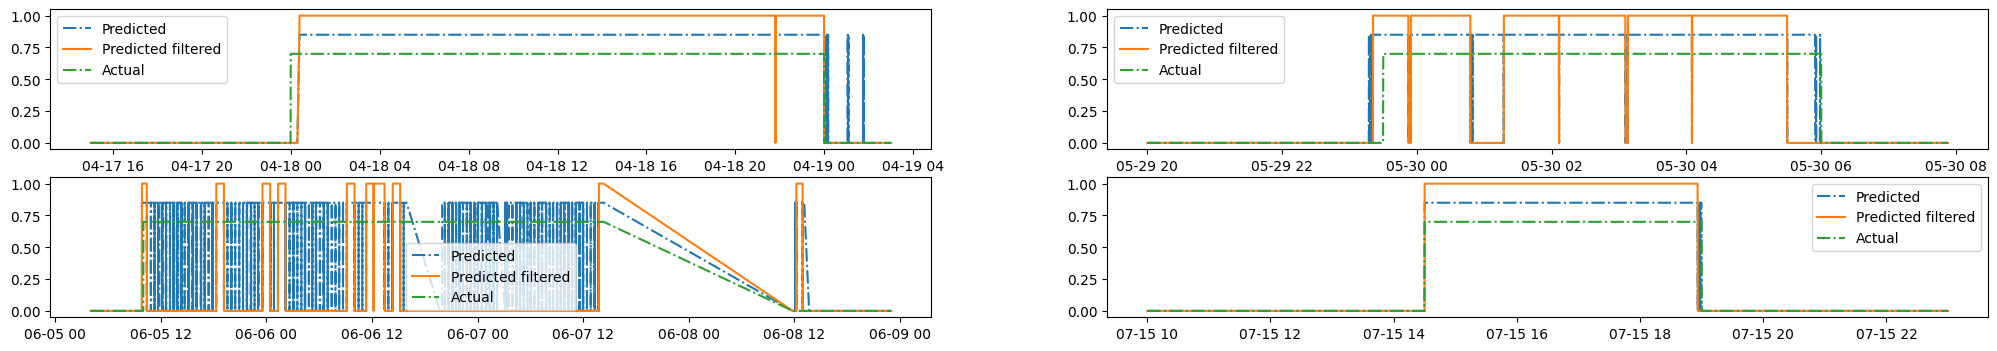

c:\Users\jvict\OneDrive\Documentos\GitHub\MBA-DSA-TCC\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


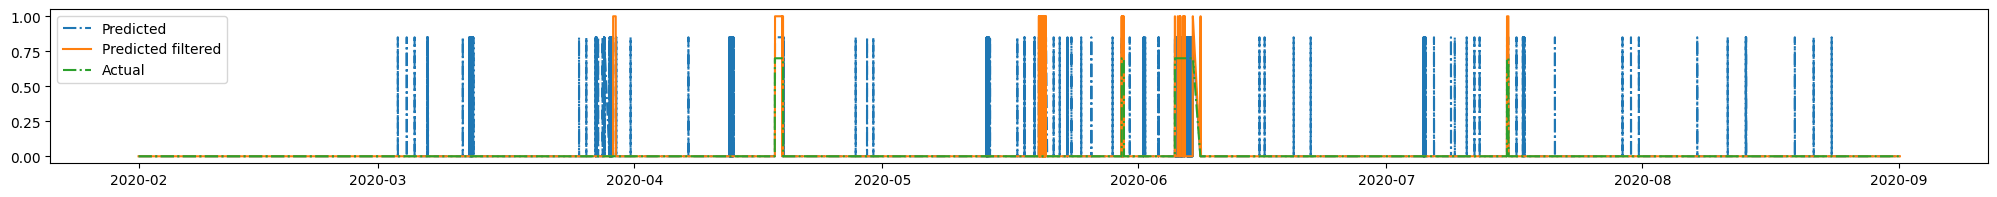

In [6]:
part = (df['ds'] > '2020-04-16 12:00:00') & (df['ds'] < '2020-04-20 12:00:00') | (df['ds'] > '2020-07-13 23:30:00') & (df['ds'] < '2020-07-16 09:00:00')
df_part, X_train, y_train, X_test, y_test = filtrar_df(['ds', 'DV_pressure', 'Oil_temperature', 'TP2', 'y'], df_treino=part)
randomForest = RandomForestClassifier(max_depth=82, random_state=0).fit(X_train, y_train)
avaliarModelo(X_test, y_test, randomForest.predict(X_test), df, filtro_minutos=30)

## Usando SVM

accuracy: 0.9868545263252267

precision: 0.6081171566192194

f1: 0.7384752586919173


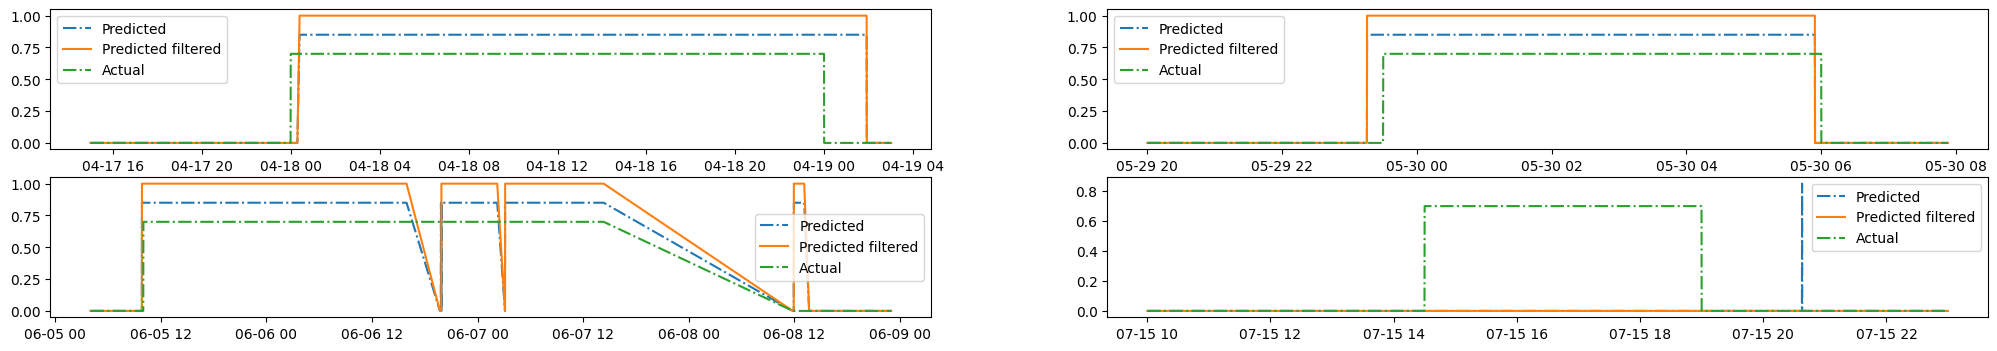

c:\Users\jvict\OneDrive\Documentos\GitHub\MBA-DSA-TCC\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


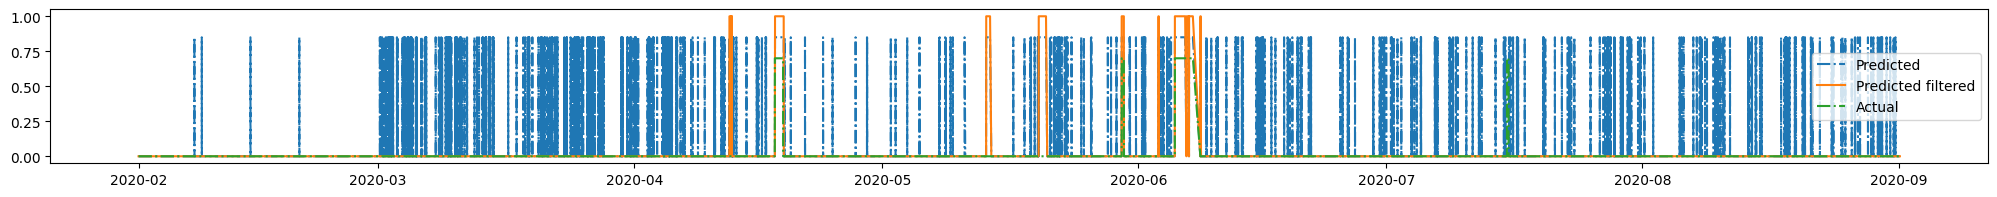

In [7]:
part = (df['ds'] > '2020-04-15 00:00:00') & (df['ds'] < '2020-04-22 23:59:00') | (df['ds'] > '2020-05-27 23:30:00') & (df['ds'] < '2020-06-03 14:30:00')
df_part, X_train, y_train, X_test, y_test = filtrar_df(['ds', 'DV_pressure', 'Oil_temperature', 'TP2', 'y'], df_treino=part)

svm_model = SVC(kernel='rbf', gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

avaliarModelo(X_test, y_test, svm_model.predict(X_test), df, filtro_minutos=50)

accuracy: 0.9830495178476784

precision: 0.5384768993373876

f1: 0.6976257393840328


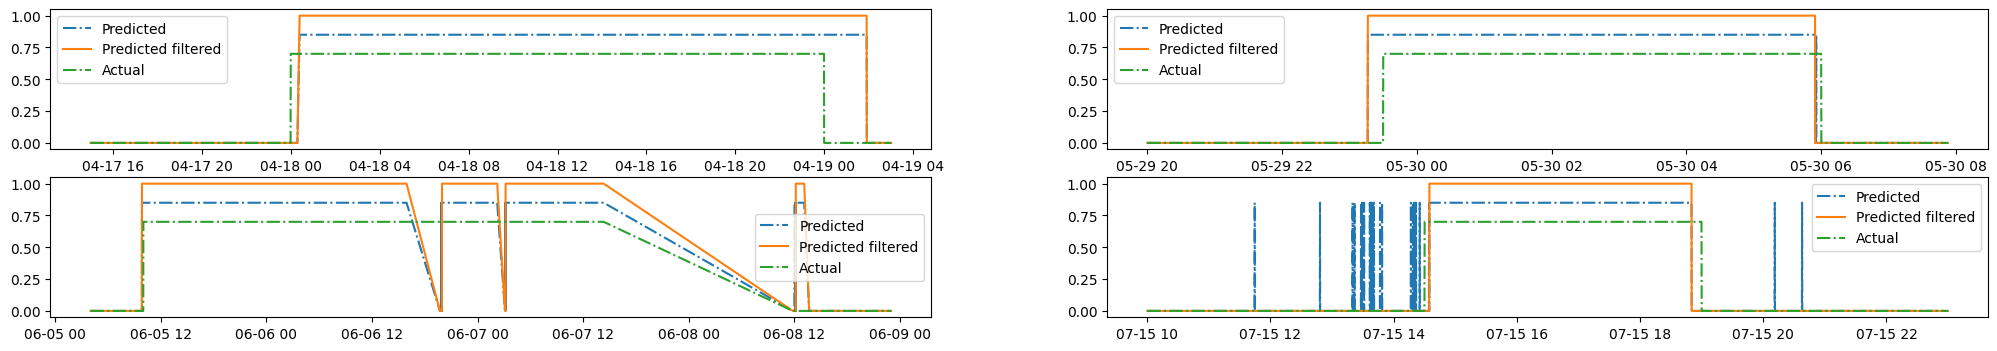

c:\Users\jvict\OneDrive\Documentos\GitHub\MBA-DSA-TCC\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


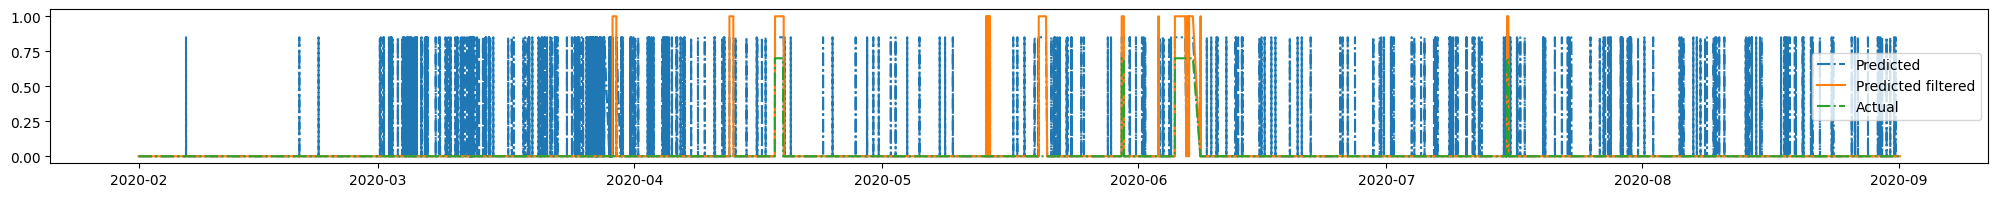

In [ ]:
part = (df['ds'] > '2020-04-16 12:00:00') & (df['ds'] < '2020-04-20 12:00:00') | (df['ds'] > '2020-07-13 23:30:00') & (df['ds'] < '2020-07-16 09:00:00')
df_part, X_train, y_train, X_test, y_test = filtrar_df(['ds', 'DV_pressure', 'Oil_temperature', 'TP2', 'y'], df_treino=part)

svm_model = SVC(kernel='rbf', gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

avaliarModelo(X_test, y_test, svm_model.predict(X_test), df, filtro_minutos=5
0)

## Usando Isolation Forest

accuracy: 0.8894345752128616

precision: 0.12623440043407488

f1: 0.2171741687358811


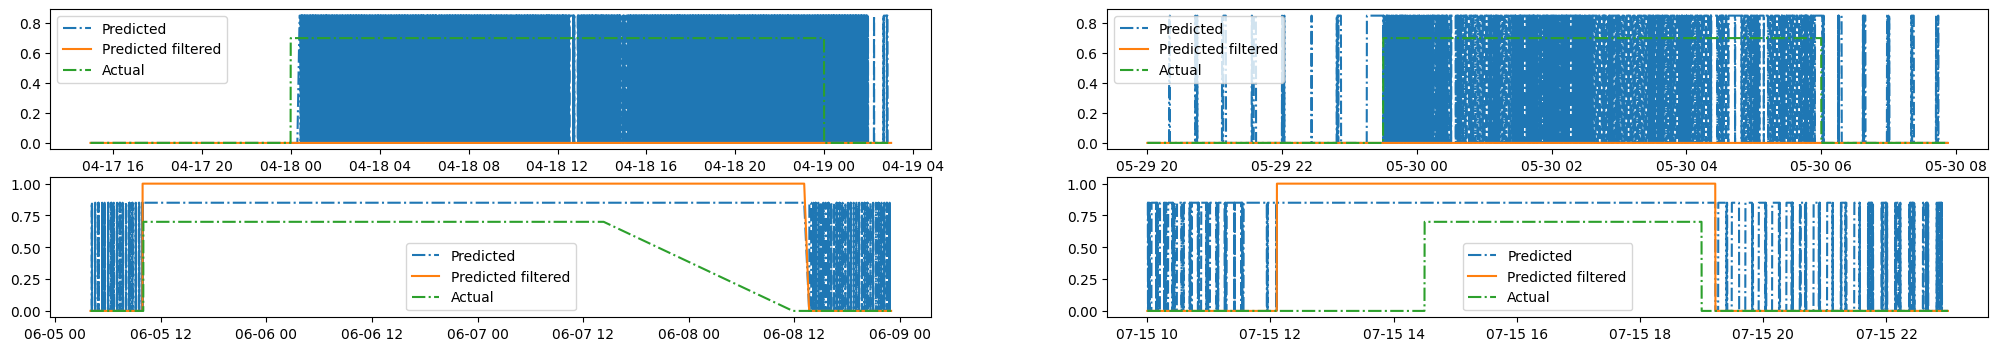

c:\Users\jvict\OneDrive\Documentos\GitHub\MBA-DSA-TCC\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


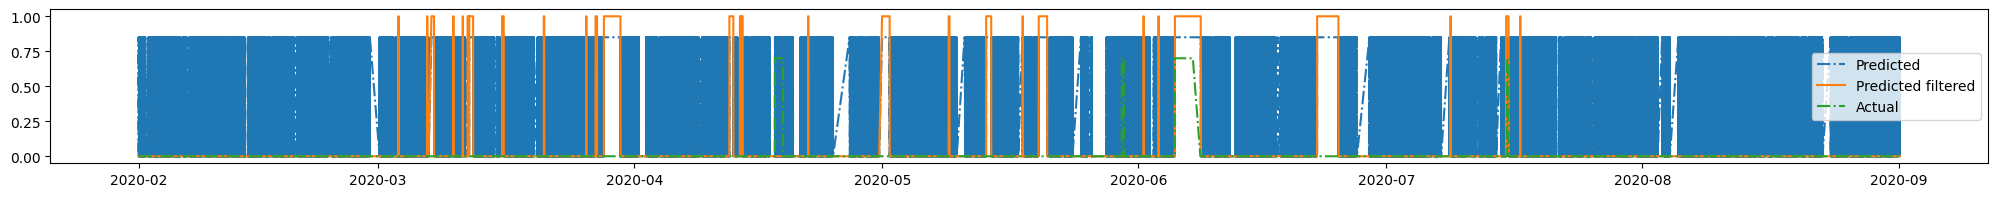

In [9]:
part = (df['ds'] > '2020-04-15 00:00:00') & (df['ds'] < '2020-04-22 23:59:00') | (df['ds'] > '2020-05-27 23:30:00') & (df['ds'] < '2020-06-03 14:30:00')

df_part, X_train, y_train, X_test, y_test = filtrar_df(['ds', 'DV_pressure', 'Oil_temperature', 'TP2', 'y'], df_treino=part)

isolationForest = IsolationForest(n_estimators=50, contamination=0.1).fit(X_train)

y_pred = [True if pred == -1 else False for pred in isolationForest.predict(X_test)]
avaliarModelo(X_test, y_test, y_pred, df)

## Usando ARIMAX

In [10]:
# part = (df['ds'] > '2020-04-16 12:00:00') & (df['ds'] < '2020-04-20 12:00:00') | (df['ds'] > '2020-07-13 23:30:00') & (df['ds'] < '2020-07-16 09:00:00')
# df_part, X_train, y_train, X_test, y_test = filtrar_df(['ds', 'DV_pressure', 'Oil_temperature', 'TP2', 'y'], df_treino=part)

# autoArimax = auto_arima(y_train, exogenous=X_train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
# autoArimax.summary()

# threshold = 0.1
# y_pred = [True if value > threshold else False for value in autoArimax.predict(n_periods=len(X_test), exogenous=X_test)]
# avaliarModelo(X_test, y_test, y_pred, df)